# Analyze the performance of the best model
Considering that the logistic regression outperformed the other models, and the version with the network feature generalize better with respect to the one-hot encoding one, we take it as best model (logistic regression with network feature).

In [1]:
import joblib as jl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)

## Load model and Dataset

In [2]:
# Try to use real data as test data
# Load the models
model_path = "../models/log_reg_mix_full_data_norm.joblib"

model = jl.load(model_path)

# Load the data
path = "../features/normalized/"
data_names = [
    "symptoms",
    "ks_level_2_norm",
    "community_count_norm",
    "community_size_norm",
]

symptoms = np.load(path + data_names[0] + ".npz")
ks_level_2_norm = np.load(path + data_names[1] + ".npz")
community_count = np.load(path + data_names[2] + ".npz")
community_size = np.load(path + data_names[3] + ".npz")

print(community_count["X"].shape)
data_mix = np.concatenate(
    (
        community_size["X"],
        community_size["X"],
        ks_level_2_norm["X"],
        community_count["X"],
        community_count["y"].reshape(symptoms["y"].shape[0], 1),
    ),
    axis=1,
)

x = data_mix[:, :-1]
y = data_mix[:, -1].astype(int)

(246914, 3)


In [8]:
print(y.min())
print(y.max())
print(len(y))
print(len(np.unique(y)))

0
772
246914
748


## Create a 'Mapping' dataframe

In [3]:
diseases_info = pd.read_csv("../../../dataset/diseases_complete_info.csv")
all_diseases = pd.read_csv("../../../dataset/disease_label_mapping.csv")

y_df = pd.DataFrame(y, columns=["Disease_num"])

tmp = pd.merge(y_df, all_diseases, on="Disease_num", how="left")
print(len(tmp["Disease"].unique()))


complete_df = pd.merge(tmp, diseases_info, on="Disease", how="left")
print(len(complete_df["Disease"].unique()))
complete_df = complete_df[["Disease", "Disease_num", "Class"]]


class_mapping = pd.Series(
    complete_df["Class"].values, index=complete_df["Disease_num"]
).to_dict()
name_mapping = pd.Series(
    complete_df["Class"].values, index=complete_df["Disease"]
).to_dict()

748
748


## Map the classes and pedictions

In [4]:
disease_num_series = pd.Series(y)
y_class = disease_num_series.map(class_mapping).values

y_class[np.isnan(y_class)] = 1 # type: ignore


pred = model.predict(x)
disease_num_series = pd.Series(pred)
pred_class = disease_num_series.map(class_mapping).values
pred_class[np.isnan(pred_class)] = 1 # type: ignore

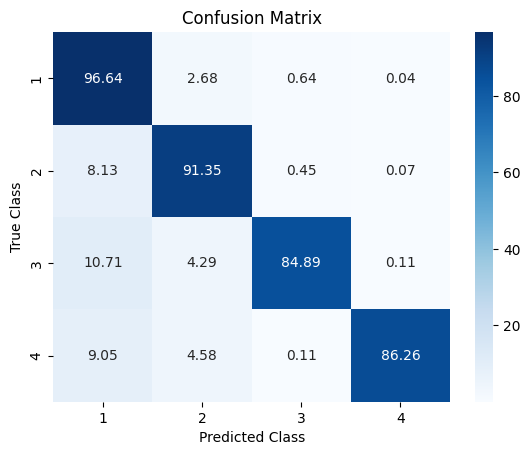

In [5]:
conf_matrix_class = confusion_matrix(y_class, pred_class)  # type: ignore

conf_matrix_class_percent = (
    conf_matrix_class / np.sum(conf_matrix_class, axis=1, keepdims=True) * 100
)

# Plot the confusion matrix with percentages
sns.heatmap(
    conf_matrix_class_percent,
    annot=True,
    fmt=".2f",  # Format as percentage with two decimal places
    cmap="Blues",
    cbar=True,
    xticklabels=np.unique(y_class).astype(int),  # type: ignore
    yticklabels=np.unique(y_class).astype(int),  # type: ignore
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

## Get accuracy for each class

In [6]:
conf_matrix = confusion_matrix(y, pred)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True)


accuracies = [conf_matrix_percent[i, i] for i in range(len(conf_matrix_percent))]

accuracies_df = pd.DataFrame({"Disease_num": np.unique(y), "Accuracy": accuracies})

## It's impossible to visualize the whole confusion matrix, so we try a different approach

,Disease_num,Disease,precision,recall,f1-score,Accuracy
0,0,fracture of the pelvis,0.814765,0.895280,0.853127,0.895280
1,1,testicular cancer,0.960000,1.000000,0.979592,1.000000
2,2,injury to the arm,0.983908,0.959641,0.971623,0.959641
3,3,heat stroke,0.770642,0.965517,0.857143,0.965517
4,4,sporotrichosis,0.212121,1.000000,0.350000,1.000000
...,...,...,...,...,...,...
743,768,induced abortion,0.998503,0.976574,0.987417,0.976574
744,769,pelvic inflammatory disease,0.931138,0.931138,0.931138,0.931138
745,770,thyroid nodule,0.838710,0.975000,0.901734,0.975000
746,771,diverticulitis,1.000000,0.800000,0.888889,0.800000


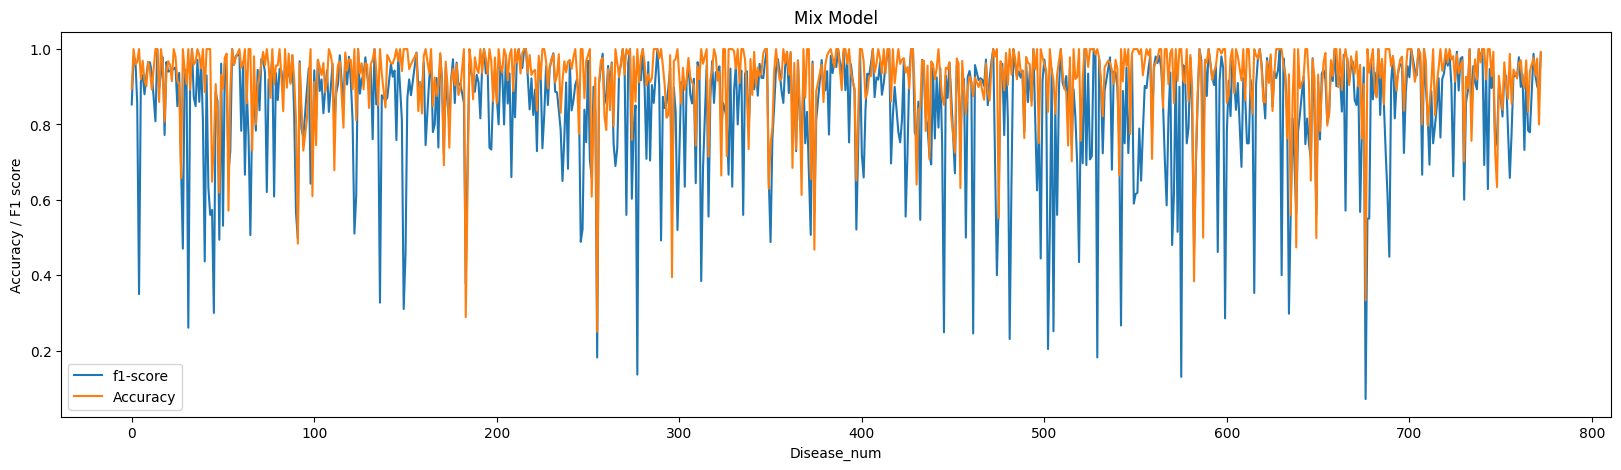

In [7]:
all_diseases = pd.read_csv("../../../dataset/disease_label_mapping.csv")

report = classification_report(y, pred, output_dict=True)

report_df = pd.DataFrame(report)
report_df = report_df.drop(columns=["accuracy", "macro avg", "weighted avg"])


report_df = report_df.transpose()
report_df["Disease_num"] = report_df.index

report_df = report_df.sort_values(by="f1-score", ascending=False)
report_df = report_df.reset_index()


# Convert 'Disease_num' column in complete_df to int64
report_df["Disease_num"] = report_df["Disease_num"].astype(int)


report_df = pd.merge(report_df, complete_df, on="Disease_num")
report_df = pd.merge(report_df, accuracies_df, on="Disease_num")

report_df = report_df.drop(columns=["index", "support", "Class"])
report_df = report_df.groupby(["Disease_num", "Disease"]).mean()
report_df = report_df.reset_index()
report_df.plot(
    kind="line", x="Disease_num", title='Mix Model', y=["f1-score","Accuracy"],ylabel="Accuracy / F1 score", figsize=(20, 5))
report_df

## Get the most relevant features 

<Axes: title={'center': 'Top 30 most important features'}, xlabel='Symptom', ylabel='Mean ABS Weights'>

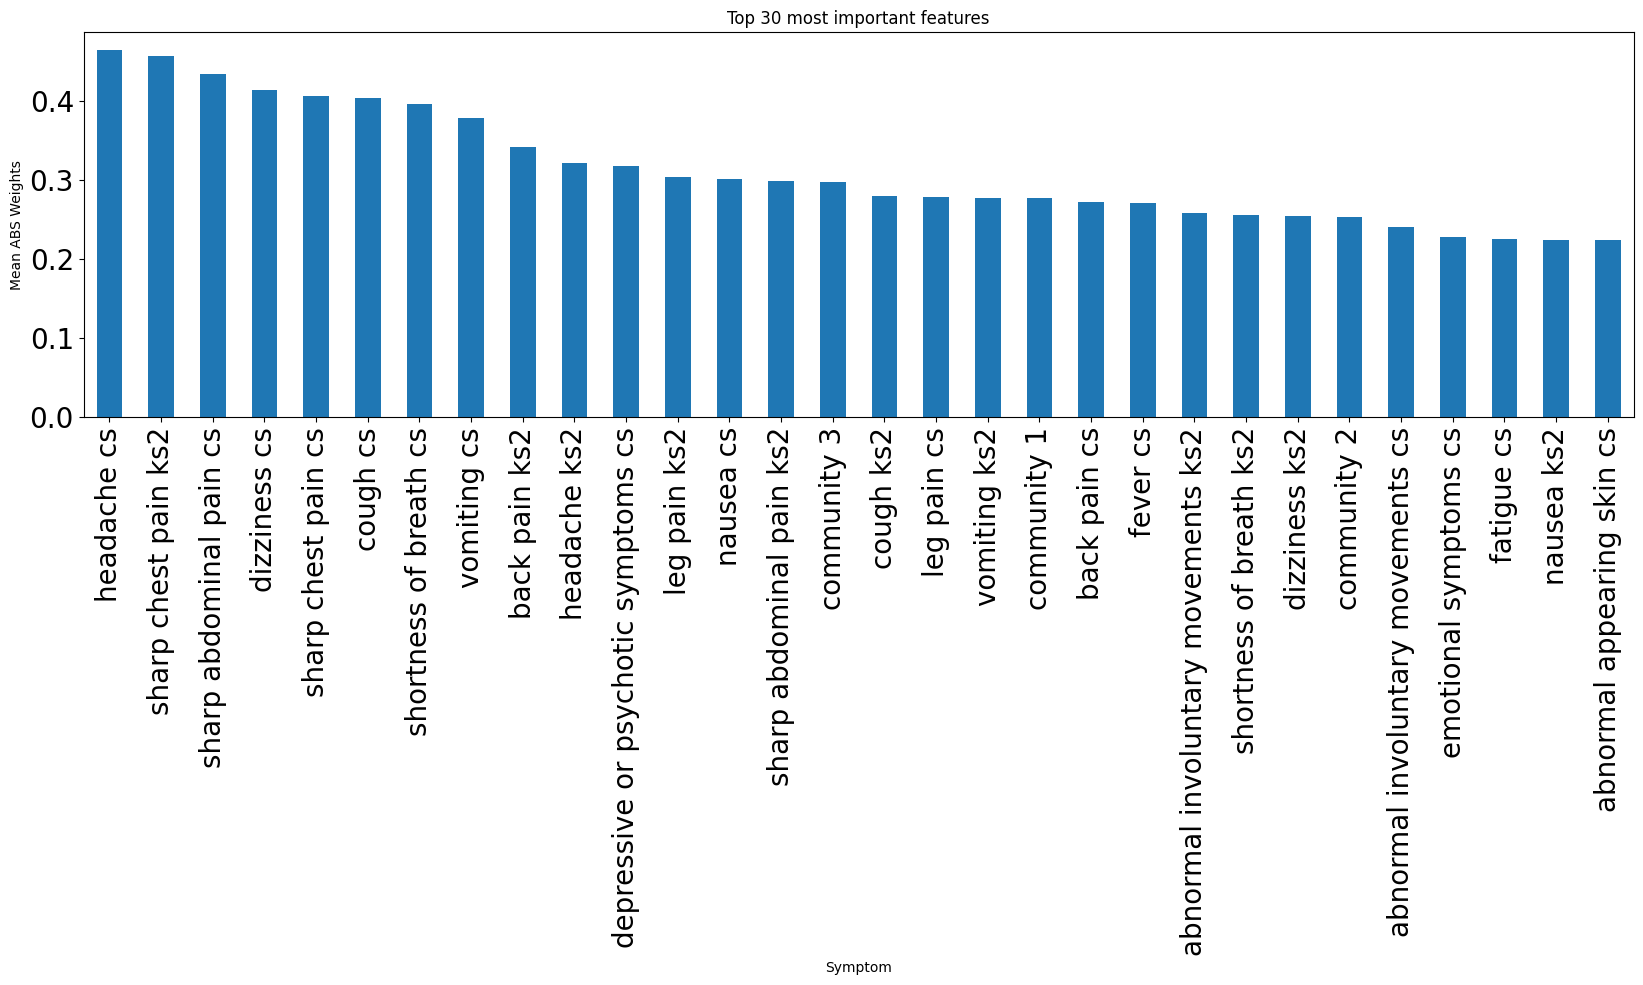

In [33]:
# Get the coefficients
coefficients = model.coef_
# Calculate the absolute values of the coefficients
absolute_coefficients = np.abs(coefficients)

# Compute the average absolute value across all classes (diseases)
average_absolute_coefficients = np.mean(absolute_coefficients, axis=0)
names = pd.read_csv("../../../dataset/symptoms.csv").values[:, 0]
names_cs = [name + " cs" for name in names]
names_ks = [name + " ks2" for name in names]
names_cc = ["community 1", "community 2", "community 3"]
names = np.concatenate((names_cs, names_cs, names_ks, names_cc))
coefficients_df = pd.DataFrame(
    {"Symptom": names, "Coefficient": average_absolute_coefficients}
)
coefficients_df = coefficients_df.drop_duplicates(subset="Symptom", keep="first")
coefficients_df = coefficients_df.sort_values(by="Coefficient", ascending=False)
coefficients_df.head(30).plot(
    kind="bar",
    x="Symptom",
    y="Coefficient",
    ylabel="Mean ABS Weights",
    figsize=(20, 5),
    fontsize=20,
    legend=False,
    title="Top 30 most important features",
)

## Get diseases with the highest accuracy

In [15]:
report_df=report_df.sort_values(by="Accuracy", ascending=False)
best_diseases=report_df[['Disease_num','Disease','Accuracy','f1-score']].head(10)
best_diseases.sort_values(by="f1-score", ascending=False)

,Disease_num,Disease,Accuracy,f1-score
685,708,mitral valve disease,1.0,1.000000
682,705,syndrome of inappropriate secretion of adh (si...,1.0,1.000000
453,472,acute bronchospasm,1.0,1.000000
411,428,eye alignment disorder,1.0,1.000000
410,427,reactive arthritis,1.0,1.000000
57,59,joint effusion,1.0,0.985507
401,417,anal fistula,1.0,0.823529
425,442,open wound of the shoulder,1.0,0.791667
62,64,alzheimer disease,1.0,0.769231
60,62,infectious gastroenteritis,1.0,0.666667


## Get the diseases with the lowest accuracy

In [16]:
worst_diseases = report_df[["Disease_num", "Disease", "Accuracy", "f1-score"]].tail(10)
worst_diseases

,Disease_num,Disease,Accuracy,f1-score
567,587,premature ventricular contractions (pvcs),0.500000,0.666667
627,649,histoplasmosis,0.498876,0.560252
89,91,hemiplegia,0.483908,0.496462
616,638,acute bronchiolitis,0.473684,0.562500
361,374,poisoning due to antimicrobial drugs,0.467849,0.567968
285,296,open wound of the mouth,0.394890,0.564315
562,582,acute otitis media,0.383938,0.468456
654,676,vitamin b12 deficiency,0.333333,0.071429
173,183,bladder cancer,0.288740,0.378102
245,255,otitis media,0.250000,0.181818


### Get the diseases mispredicted as 'bladder cancer'

173


<Axes: title={'center': 'Bladder cancer missclassified samples'}, xlabel='Disease', ylabel='Percentage of missclassified samples'>

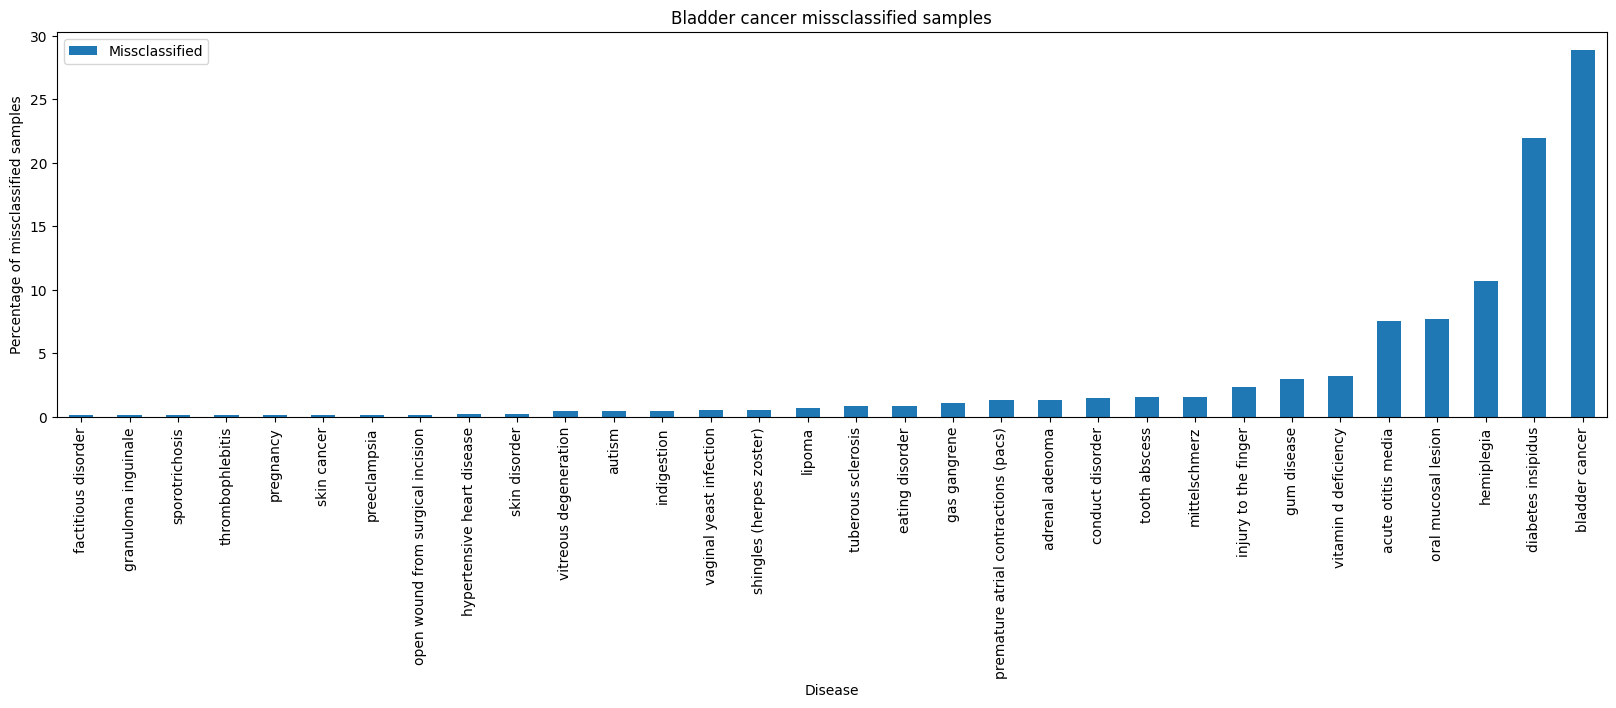

In [17]:
order = np.array(np.unique(y))
pos_conf_matrix_bc = np.where(
    order
    == worst_diseases[worst_diseases["Disease"] == "bladder cancer"][
        "Disease_num"
    ].values[0]
)[0][0]

missclassified = conf_matrix_percent[pos_conf_matrix_bc, :]

bladder_cancer_df = pd.DataFrame(
    {"Disease_num": order, "Missclassified": missclassified}
)
bladder_cancer_df = pd.merge(bladder_cancer_df, complete_df, on="Disease_num")
bladder_cancer_df = bladder_cancer_df[bladder_cancer_df["Missclassified"] > 0]
print(pos_conf_matrix_bc)
bladder_cancer_df = (
    bladder_cancer_df[["Disease", "Missclassified"]].groupby("Disease").mean()
)
bladder_cancer_df["Missclassified"] = bladder_cancer_df["Missclassified"] * 100
bladder_cancer_df.sort_values(by="Missclassified", ascending=True).plot(
    kind="bar",
    figsize=(20, 5),
    ylabel="Percentage of missclassified samples",
    title="Bladder cancer missclassified samples",
    xlabel="Disease",
)

### Get the diseases mispredicted as 'otitis media'

245


<Axes: title={'center': 'Otitis media missclassified samples'}, xlabel='Disease', ylabel='Percentage of missclassified samples'>

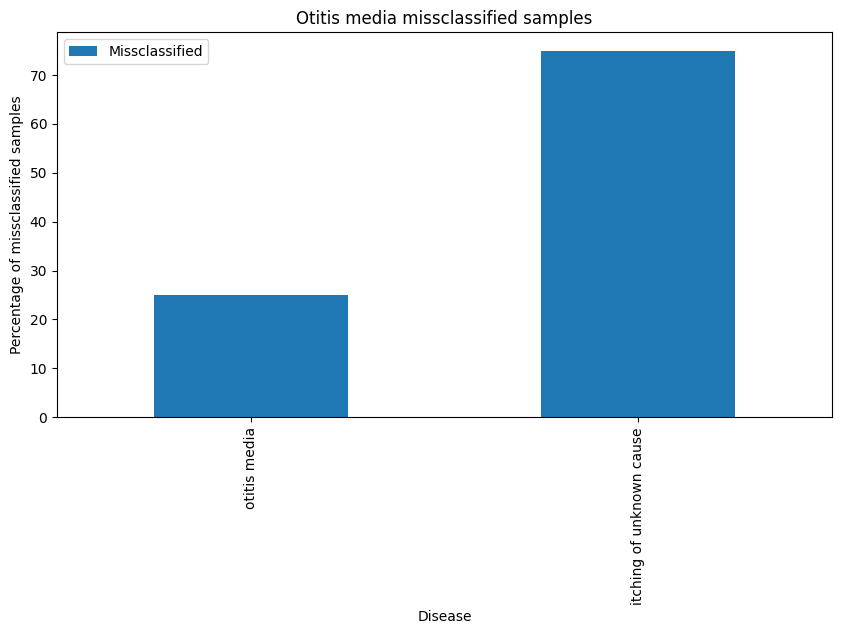

In [18]:
order = np.array(np.unique(y))
pos_conf_matrix_om = np.where(
    order
    == worst_diseases[worst_diseases["Disease"] == "otitis media"][
        "Disease_num"
    ].values[0]
)[0][0]

missclassified = conf_matrix_percent[pos_conf_matrix_om, :]

otitis_media_df = pd.DataFrame(
    {"Disease_num": order, "Missclassified": missclassified}
)
otitis_media_df = pd.merge(otitis_media_df, complete_df, on="Disease_num")
otitis_media_df = otitis_media_df[otitis_media_df["Missclassified"] > 0]
print(pos_conf_matrix_om)
otitis_media_df = (
    otitis_media_df[["Disease", "Missclassified"]].groupby("Disease").mean()
)
otitis_media_df["Missclassified"] = otitis_media_df["Missclassified"] * 100
otitis_media_df.sort_values(by="Missclassified", ascending=True).plot(
    kind="bar",
    figsize=(10, 5),
    ylabel="Percentage of missclassified samples",
    title="Otitis media missclassified samples",
    xlabel="Disease",
)

## Try to explain the mispredictions

### 1- They have the less number of samples 

In [19]:
bladder_cancer_num = worst_diseases[worst_diseases["Disease"] == "bladder cancer"][
    "Disease_num"
].values[0]

otitis_media_num = worst_diseases[worst_diseases["Disease"] == "otitis media"][
    "Disease_num"
].values[0]

itching_num = complete_df[complete_df["Disease"] == "itching of unknown cause"][
    "Disease_num"
].values[0]

bladder_cancer_count = np.count_nonzero(y == bladder_cancer_num)
otitis_media_count = np.count_nonzero(y == otitis_media_num)
itching_count = np.count_nonzero(y == itching_num)


print("Percentage of sample of bladder cancer : ", bladder_cancer_count / len(y) * 100)
print("Percentage of sample of otitis media : ", otitis_media_count / len(y) * 100)
print("Percentage of sample of itching : ", itching_num / len(y) * 100)

Percentage of sample of bladder cancer :  0.3632843824165499
Percentage of sample of otitis media :  0.0016199972460046817
Percentage of sample of itching :  0.018224969017552668


### 2- They have similar symptoms

#### 2.1- Bladder cancer, diabetes insipidus and hemiplegia

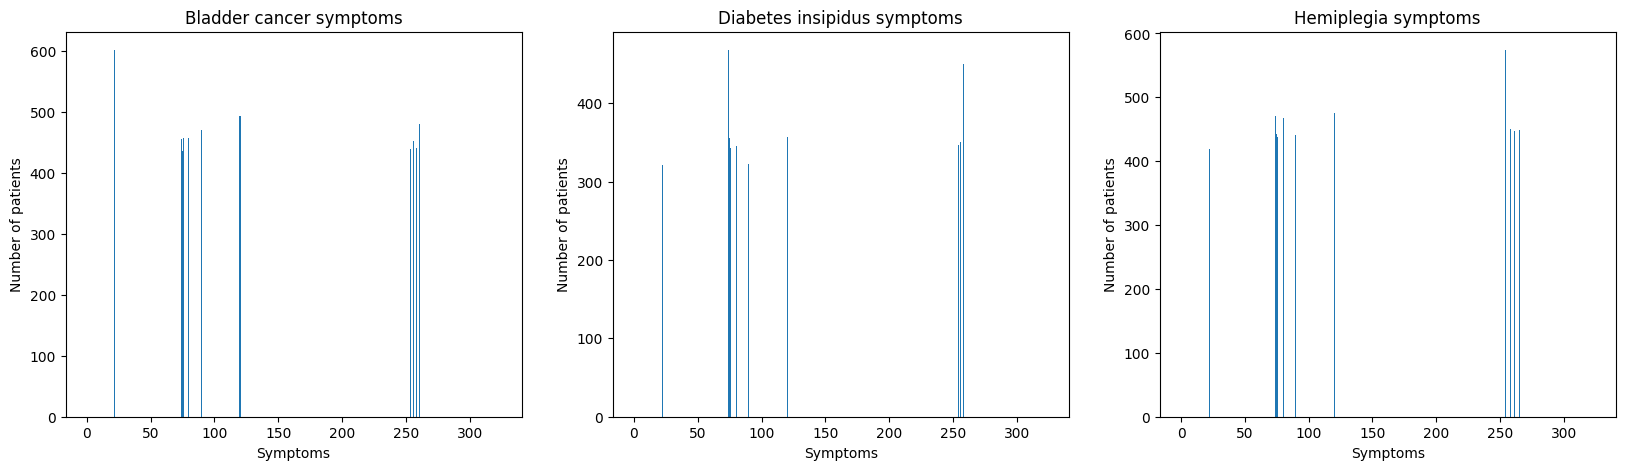

In [20]:
symptoms = np.load(path + data_names[0] + ".npz")

# Take the symptoms of 'bladder cancer' and 'diabetes insipidus' and plot them
bladder_cancer = complete_df[complete_df["Disease"] == "bladder cancer"]
bladder_cancer = bladder_cancer["Disease_num"].values[0]

insipidus = complete_df[complete_df["Disease"] == "diabetes insipidus"]
insipidus = insipidus["Disease_num"].values[0]

hemiplegia = complete_df[complete_df["Disease"] == "hemiplegia"]
hemiplegia = hemiplegia["Disease_num"].values[0]

bladder_cancer_symptoms = symptoms["X"][y == bladder_cancer]
insipidus_symptoms = symptoms["X"][y == insipidus]
hemiplegia_symptoms = symptoms["X"][y == hemiplegia]

bladder_cancer_symptoms = np.sum(bladder_cancer_symptoms, axis=0)
insipidus_symptoms = np.sum(insipidus_symptoms, axis=0)
hemiplegia_symptoms = np.sum(hemiplegia_symptoms, axis=0)

# plot

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.bar(np.arange(len(bladder_cancer_symptoms)), bladder_cancer_symptoms)
plt.title("Bladder cancer symptoms")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")

plt.subplot(1, 3, 2)
plt.bar(np.arange(len(insipidus_symptoms)), insipidus_symptoms)
plt.title("Diabetes insipidus symptoms")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")

plt.subplot(1, 3, 3)
plt.bar(np.arange(len(hemiplegia_symptoms)), hemiplegia_symptoms)
plt.title("Hemiplegia symptoms")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")
plt.show()

In [21]:
################# Bladder cancer and diabetes insipidus ######################

# get the symptoms in common between the two diseases
common_symptoms_bd = np.logical_and(bladder_cancer_symptoms, insipidus_symptoms)
common_symptoms_bd = np.where(common_symptoms_bd == True)[0]

# compute the ratio of symptoms which are shared between the two diseases
num_symptoms_cancer = np.count_nonzero(bladder_cancer_symptoms)
num_symptoms_insipidus = np.count_nonzero(insipidus_symptoms)
num_common_symptoms = len(common_symptoms_bd)

ratio_cancer = num_common_symptoms / num_symptoms_cancer
ratio_insipidus = num_common_symptoms / num_symptoms_insipidus

print("Bladder cancer and diabetes insipidus")
print("Ratio of common symptoms for bladder cancer: ", ratio_cancer)
print("Ratio of common symptoms for diabetes insipidus: ", ratio_insipidus)

################# Bladder cancer and hemiplegia ######################

# get the symptoms in common between the two diseases
common_symptoms_bh = np.logical_and(bladder_cancer_symptoms, hemiplegia_symptoms)
common_symptoms_bh = np.where(common_symptoms_bh == True)[0]

# compute the ratio of symptoms which are shared between the two diseases
num_symptoms_cancer = np.count_nonzero(bladder_cancer_symptoms)
num_symptoms_hemiplegia = np.count_nonzero(hemiplegia_symptoms)
num_common_symptoms = len(common_symptoms_bh)

ratio_cancer = num_common_symptoms / num_symptoms_cancer
ratio_hemiplegia = num_common_symptoms / num_symptoms_hemiplegia
print("\nBladder cancer and hemiplegia")
print("Ratio of common symptoms for bladder cancer: ", ratio_cancer)
print("Ratio of common symptoms for hemiplegia: ", ratio_hemiplegia)

Bladder cancer and diabetes insipidus
Ratio of common symptoms for bladder cancer:  0.9090909090909091
Ratio of common symptoms for diabetes insipidus:  1.0

Bladder cancer and hemiplegia
Ratio of common symptoms for bladder cancer:  0.9090909090909091
Ratio of common symptoms for hemiplegia:  0.9090909090909091


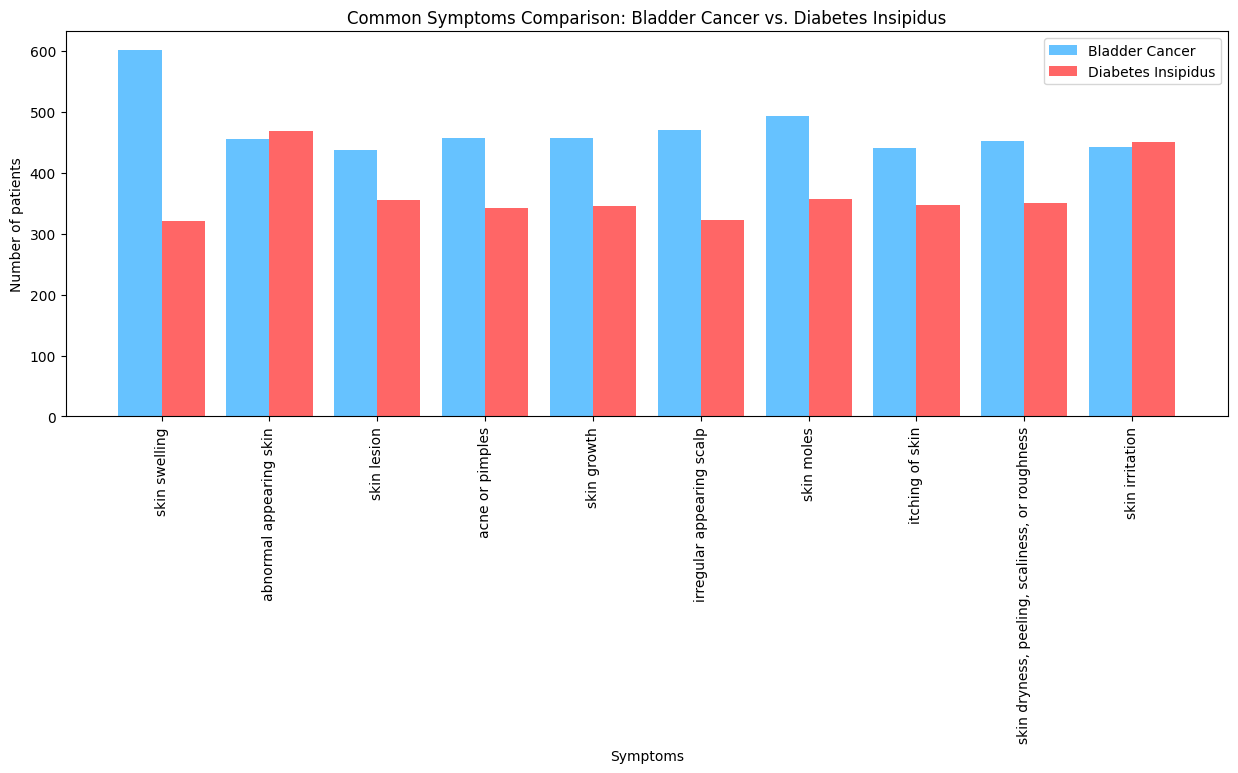

In [22]:
# Get symptoms names
names = pd.read_csv("../../../dataset/symptoms.csv").values[:, 0]
names[:][common_symptoms_bd]

# plot the number of patients for these symptoms for each disease
# Use the same barplot with two bars for each symptom

bladder_cancer_symptoms1 = bladder_cancer_symptoms[common_symptoms_bd]
insipidus_symptoms = insipidus_symptoms[common_symptoms_bd]

# Set the width of the bars
bar_width = 0.4

# Create positions for the bars
positions1 = np.arange(len(bladder_cancer_symptoms1))
positions2 = positions1 + bar_width

# Plot the bar chart
plt.figure(figsize=(15, 5))

plt.bar(
    positions1,
    bladder_cancer_symptoms1,
    width=bar_width,
    label="Bladder Cancer",
    color="#66c2ff",
)
plt.bar(
    positions2,
    insipidus_symptoms,
    width=bar_width,
    label="Diabetes Insipidus",
    color="#ff6666",
)

plt.title("Common Symptoms Comparison: Bladder Cancer vs. Diabetes Insipidus")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")
plt.xticks((positions1 + positions2) / 2, names[common_symptoms_bd], rotation=90)
plt.legend()

plt.show()

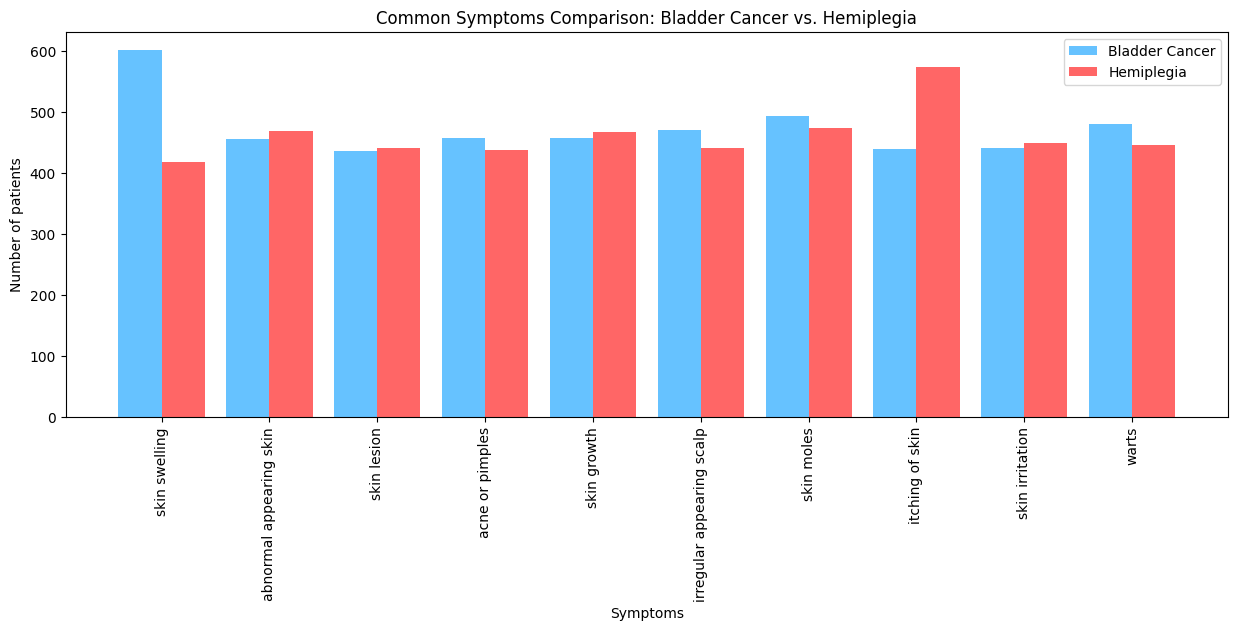

In [23]:
# Get symptoms names
names = pd.read_csv("../../../dataset/symptoms.csv").values[:, 0]
names[:][common_symptoms_bh]

# plot the number of patients for these symptoms for each disease
# Use the same barplot with two bars for each symptom

bladder_cancer_symptoms2 = bladder_cancer_symptoms[common_symptoms_bh]
hemiplegia_symptoms = hemiplegia_symptoms[common_symptoms_bh]

# Set the width of the bars
bar_width = 0.4

# Create positions for the bars
positions1 = np.arange(len(bladder_cancer_symptoms2))
positions2 = positions1 + bar_width

# Plot the bar chart
plt.figure(figsize=(15, 5))

plt.bar(
    positions1,
    bladder_cancer_symptoms2,
    width=bar_width,
    label="Bladder Cancer",
    color="#66c2ff",
)
plt.bar(
    positions2,
    hemiplegia_symptoms,
    width=bar_width,
    label="Hemiplegia",
    color="#ff6666",
)

plt.title("Common Symptoms Comparison: Bladder Cancer vs. Hemiplegia")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")
plt.xticks((positions1 + positions2) / 2, names[common_symptoms_bh], rotation=90)
plt.legend()

plt.show()

#### 2.2- Otitis media and ithcing for unknown causes

Text(0.5, 0, 'Symptoms')

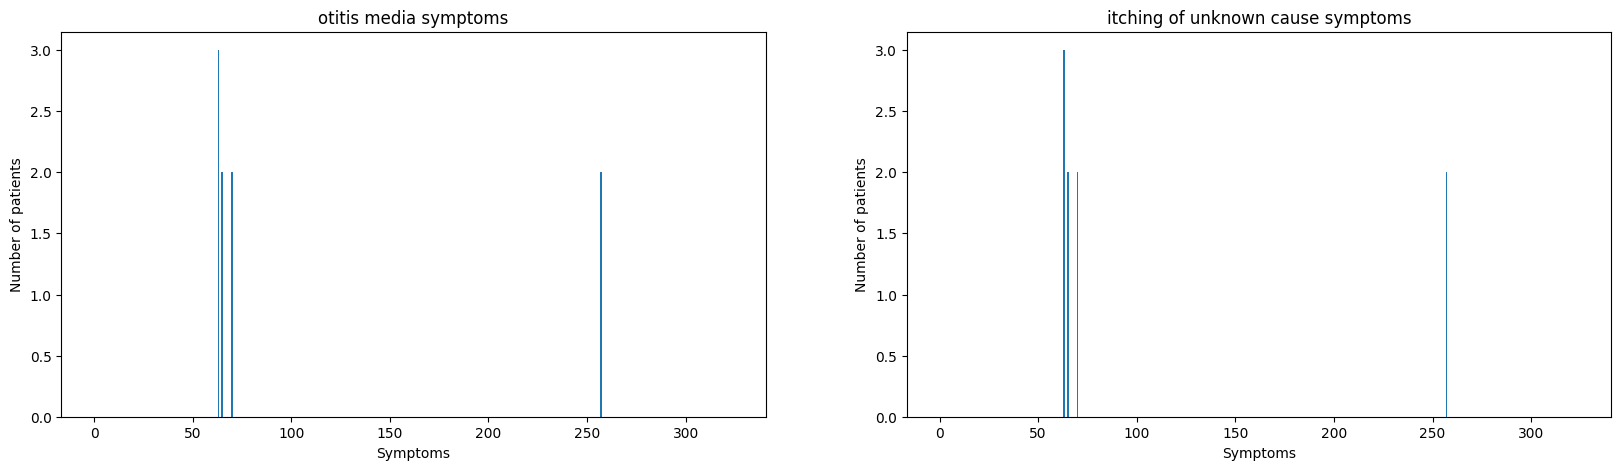

In [24]:
symptoms = np.load(path + data_names[0] + ".npz")

# Take the symptoms of 'otitis media' and 'itching of unknown cause' and plot them
otitis = complete_df[complete_df["Disease"] == "otitis media"]
otitis = otitis["Disease_num"].values[0]

itching = complete_df[complete_df["Disease"] == "itching of unknown cause"]
itching = itching["Disease_num"].values[0]


otitis_symptoms = symptoms["X"][y == otitis]
itching_symptoms = symptoms["X"][y == itching]

otitis_symptoms = np.sum(otitis_symptoms, axis=0)
itching_symptoms = np.sum(itching_symptoms, axis=0)

# plot

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(otitis_symptoms)), otitis_symptoms)
plt.title("otitis media symptoms")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")

plt.subplot(1, 2, 2)
plt.bar(np.arange(len(itching_symptoms)), itching_symptoms)
plt.title("itching of unknown cause symptoms")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")



In [25]:
################# otitis and itching of unknown cause ######################

# get the symptoms in common between the two diseases
common_symptoms_bd = np.logical_and(otitis_symptoms, itching_symptoms)
common_symptoms_bd = np.where(common_symptoms_bd == True)[0]

# compute the ratio of symptoms which are shared between the two diseases
num_symptoms_otitis = np.count_nonzero(otitis_symptoms)
num_symptoms_itching = np.count_nonzero(itching_symptoms)
num_common_symptoms = len(common_symptoms_bd)

ratio_otitis = num_common_symptoms / num_symptoms_otitis
ratio_itching = num_common_symptoms / num_symptoms_itching

print("Otitis and itching of unknown cause")
print("Ratio of common symptoms for otitis: ", ratio_otitis)
print("Ratio of common symptoms for itching of unknown cause: ", ratio_itching)

Otitis and itching of unknown cause
Ratio of common symptoms for otitis:  1.0
Ratio of common symptoms for itching of unknown cause:  1.0


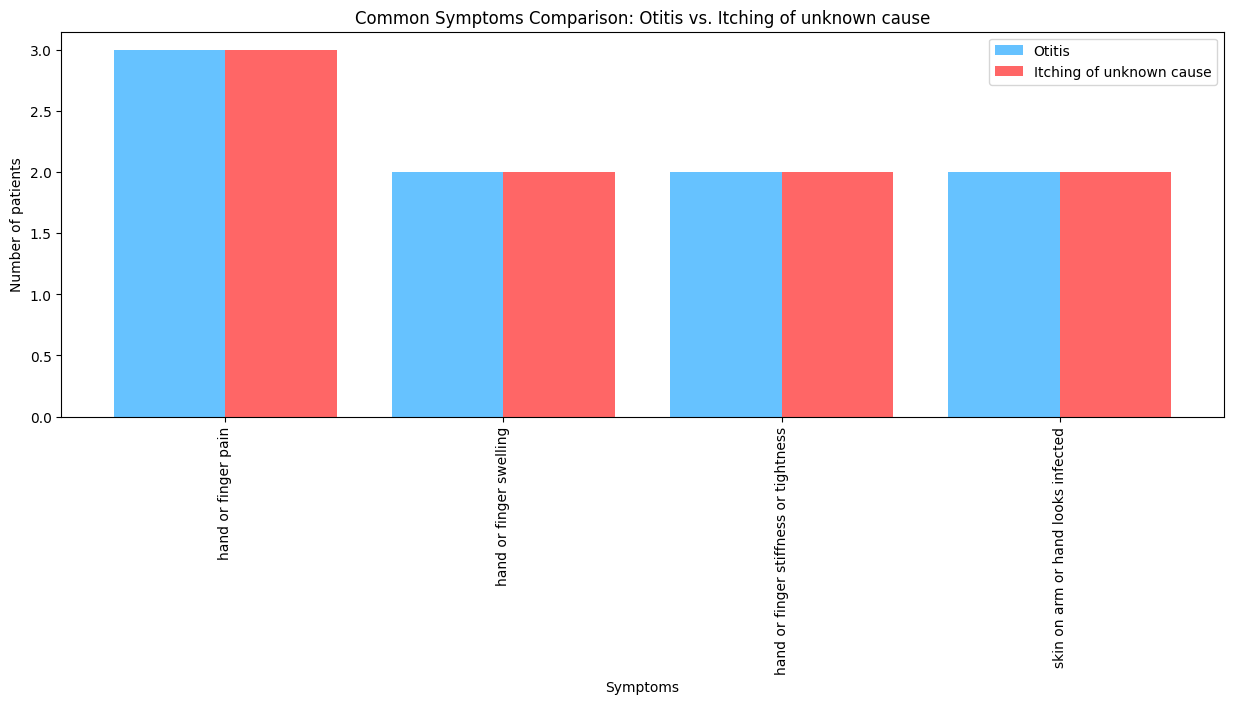

In [26]:
# Get symptoms names
names = pd.read_csv('../../../dataset/symptoms.csv').values[:,0]
names[:][common_symptoms_bd]

# plot the number of patients for these symptoms for each disease
# Use the same barplot with two bars for each symptom

otitis_symptoms = otitis_symptoms[common_symptoms_bd]
itching_symptoms = itching_symptoms[common_symptoms_bd]

# Set the width of the bars
bar_width = 0.4

# Create positions for the bars
positions1 = np.arange(len(otitis_symptoms))
positions2 = positions1 + bar_width

# Plot the bar chart
plt.figure(figsize=(15, 5))

plt.bar(positions1, otitis_symptoms, width=bar_width, label='Otitis', color='#66c2ff')
plt.bar(positions2, itching_symptoms, width=bar_width, label='Itching of unknown cause', color='#ff6666')

plt.title("Common Symptoms Comparison: Otitis vs. Itching of unknown cause")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")
plt.xticks((positions1 + positions2) / 2, names[common_symptoms_bd], rotation=90)
plt.legend()

plt.show()